# TASK 3 :  MACHINE LEARNING MODEL

In [5]:
# Core Libraries
import sqlite3
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


## 2. Database Connection and Initial Data Exploration

In [6]:

DB_PATH = 'smart_home.db'

conn = sqlite3.connect(DB_PATH)

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("\nTables in database:")
print(tables)


Tables in database:
              name
0            homes
1          devices
2  sensor_readings
3           alerts


In [7]:

homes_df = pd.read_sql("SELECT * FROM homes", conn)
devices_df = pd.read_sql("SELECT * FROM devices", conn)
sensor_readings_df = pd.read_sql("SELECT * FROM sensor_readings", conn)
alerts_df = pd.read_sql("SELECT * FROM alerts", conn)


print(f"  - Homes: {len(homes_df)} records")
print(f"  - Devices: {len(devices_df)} records")
print(f"  - Sensor Readings: {len(sensor_readings_df)} records")
print(f"  - Alerts: {len(alerts_df)} records")

  - Homes: 200 records
  - Devices: 925 records
  - Sensor Readings: 222000 records
  - Alerts: 77 records


In [8]:

print("Device Status Distribution:")
print(devices_df['status'].value_counts())
print(f"\nOffline Rate: {(devices_df['status'] == 'offline').mean()*100:.2f}%")

Device Status Distribution:
status
active     687
offline    238
Name: count, dtype: int64

Offline Rate: 25.73%


##  Feature Engineering SQL


In [9]:
# FEATURE ENGINEERING SQL QUERY
# This comprehensive query extracts features for each device

feature_engineering_sql = """
WITH
-- Device age and basic info
device_info AS (
    SELECT
        d.device_id,
        d.home_id,
        d.device_type,
        d.install_date,
        d.status,
        -- Calculate device age in days
        CAST(julianday('2025-11-16') - julianday(d.install_date) AS INTEGER) AS device_age_days,
        h.city,
        h.home_type
    FROM devices d
    JOIN homes h ON d.home_id = h.home_id
),

-- Sensor reading statistics per device
sensor_stats AS (
    SELECT
        device_id,
        COUNT(*) AS total_readings,
        COUNT(DISTINCT DATE(reading_datetime)) AS active_days,
        AVG(value_numeric) AS avg_numeric_value,
        MAX(value_numeric) AS max_numeric_value,
        MIN(value_numeric) AS min_numeric_value,
        -- Variance approximation
        AVG(value_numeric * value_numeric) - AVG(value_numeric) * AVG(value_numeric) AS variance_numeric,
        -- Readings per day
        COUNT(*) * 1.0 / NULLIF(COUNT(DISTINCT DATE(reading_datetime)), 0) AS readings_per_day
    FROM sensor_readings
    GROUP BY device_id
),

-- Sensor reading patterns by metric type
metric_breakdown AS (
    SELECT
        device_id,
        SUM(CASE WHEN metric_type = 'temperature' THEN 1 ELSE 0 END) AS temp_readings,
        SUM(CASE WHEN metric_type = 'motion' THEN 1 ELSE 0 END) AS motion_readings,
        SUM(CASE WHEN metric_type = 'camera_motion' THEN 1 ELSE 0 END) AS camera_motion_readings,
        SUM(CASE WHEN metric_type = 'door_state' THEN 1 ELSE 0 END) AS door_state_readings,
        -- Average values by type
        AVG(CASE WHEN metric_type = 'temperature' THEN value_numeric END) AS avg_temperature,
        AVG(CASE WHEN metric_type = 'motion' THEN value_numeric END) AS avg_motion,
        -- Motion detection rate (for motion-based devices)
        AVG(CASE WHEN metric_type IN ('motion', 'camera_motion') AND value_numeric = 1 THEN 1.0 ELSE 0.0 END) AS motion_detection_rate
    FROM sensor_readings
    GROUP BY device_id
),

-- Alert statistics per device
alert_stats AS (
    SELECT
        device_id,
        COUNT(*) AS total_alerts,
        SUM(CASE WHEN severity = 'high' THEN 1 ELSE 0 END) AS high_severity_alerts,
        SUM(CASE WHEN severity = 'medium' THEN 1 ELSE 0 END) AS medium_severity_alerts,
        COUNT(DISTINCT DATE(alert_datetime)) AS days_with_alerts
    FROM alerts
    GROUP BY device_id
),

-- Home-level statistics (devices per home, offline rate in home)
home_stats AS (
    SELECT
        home_id,
        COUNT(*) AS devices_in_home,
        SUM(CASE WHEN status = 'offline' THEN 1 ELSE 0 END) AS offline_devices_in_home,
        SUM(CASE WHEN status = 'offline' THEN 1.0 ELSE 0.0 END) / COUNT(*) AS home_offline_rate
    FROM devices
    GROUP BY home_id
),

-- Recent activity (last 7 days before data cutoff)
recent_activity AS (
    SELECT
        device_id,
        COUNT(*) AS recent_readings_7d,
        AVG(value_numeric) AS recent_avg_value_7d
    FROM sensor_readings
    WHERE reading_datetime >= datetime('2025-11-09')  -- Last 7 days
    GROUP BY device_id
)

-- Final feature set
SELECT
    di.device_id,
    di.device_type,
    di.device_age_days,
    di.city,
    di.home_type,

    -- Sensor reading features
    COALESCE(ss.total_readings, 0) AS total_readings,
    COALESCE(ss.active_days, 0) AS active_days,
    COALESCE(ss.avg_numeric_value, 0) AS avg_numeric_value,
    COALESCE(ss.max_numeric_value, 0) AS max_numeric_value,
    COALESCE(ss.min_numeric_value, 0) AS min_numeric_value,
    COALESCE(ss.variance_numeric, 0) AS variance_numeric,
    COALESCE(ss.readings_per_day, 0) AS readings_per_day,

    -- Metric-specific features
    COALESCE(mb.temp_readings, 0) AS temp_readings,
    COALESCE(mb.motion_readings, 0) AS motion_readings,
    COALESCE(mb.camera_motion_readings, 0) AS camera_motion_readings,
    COALESCE(mb.door_state_readings, 0) AS door_state_readings,
    COALESCE(mb.avg_temperature, 0) AS avg_temperature,
    COALESCE(mb.avg_motion, 0) AS avg_motion,
    COALESCE(mb.motion_detection_rate, 0) AS motion_detection_rate,

    -- Alert features
    COALESCE(als.total_alerts, 0) AS total_alerts,
    COALESCE(als.high_severity_alerts, 0) AS high_severity_alerts,
    COALESCE(als.medium_severity_alerts, 0) AS medium_severity_alerts,
    COALESCE(als.days_with_alerts, 0) AS days_with_alerts,

    -- Home-level features
    hs.devices_in_home,
    hs.offline_devices_in_home,
    hs.home_offline_rate,

    -- Recent activity features
    COALESCE(ra.recent_readings_7d, 0) AS recent_readings_7d,
    COALESCE(ra.recent_avg_value_7d, 0) AS recent_avg_value_7d,

    -- Target variable
    CASE WHEN di.status = 'offline' THEN 1 ELSE 0 END AS device_failed

FROM device_info di
LEFT JOIN sensor_stats ss ON di.device_id = ss.device_id
LEFT JOIN metric_breakdown mb ON di.device_id = mb.device_id
LEFT JOIN alert_stats als ON di.device_id = als.device_id
LEFT JOIN home_stats hs ON di.home_id = hs.home_id
LEFT JOIN recent_activity ra ON di.device_id = ra.device_id
ORDER BY di.device_id;
"""

print("Feature Engineering SQL Query:")
print("="*80)
print(feature_engineering_sql)

Feature Engineering SQL Query:

WITH 
-- Device age and basic info
device_info AS (
    SELECT 
        d.device_id,
        d.home_id,
        d.device_type,
        d.install_date,
        d.status,
        -- Calculate device age in days
        CAST(julianday('2025-11-16') - julianday(d.install_date) AS INTEGER) AS device_age_days,
        h.city,
        h.home_type
    FROM devices d
    JOIN homes h ON d.home_id = h.home_id
),

-- Sensor reading statistics per device
sensor_stats AS (
    SELECT 
        device_id,
        COUNT(*) AS total_readings,
        COUNT(DISTINCT DATE(reading_datetime)) AS active_days,
        AVG(value_numeric) AS avg_numeric_value,
        MAX(value_numeric) AS max_numeric_value,
        MIN(value_numeric) AS min_numeric_value,
        -- Variance approximation
        AVG(value_numeric * value_numeric) - AVG(value_numeric) * AVG(value_numeric) AS variance_numeric,
        -- Readings per day
        COUNT(*) * 1.0 / NULLIF(COUNT(DISTINCT DATE(readin

In [10]:
# Execute the feature engineering query
ml_data = pd.read_sql(feature_engineering_sql, conn)

print(f"Feature dataset created: {ml_data.shape[0]} devices, {ml_data.shape[1]} columns")
print("\nFirst 5 rows:")
ml_data.head()

Feature dataset created: 925 devices, 29 columns

First 5 rows:


,device_id,device_type,device_age_days,city,home_type,total_readings,active_days,avg_numeric_value,max_numeric_value,min_numeric_value,variance_numeric,readings_per_day,temp_readings,motion_readings,camera_motion_readings,door_state_readings,avg_temperature,avg_motion,motion_detection_rate,total_alerts,high_severity_alerts,medium_severity_alerts,days_with_alerts,devices_in_home,offline_devices_in_home,home_offline_rate,recent_readings_7d,recent_avg_value_7d,device_failed
0,1,motion_sensor,184,Seattle,condo,240,60,0.125000,1.0,0.0,0.109375,4.0,0,240,0,0,0.00000,0.125,0.125000,0,0,0,0,6,1,0.166667,32,0.15625,0
1,2,motion_sensor,451,Seattle,condo,240,60,0.125000,1.0,0.0,0.109375,4.0,0,240,0,0,0.00000,0.125,0.125000,0,0,0,0,6,1,0.166667,32,0.09375,0
2,3,camera,409,Seattle,condo,240,60,0.091667,1.0,0.0,0.083264,4.0,0,0,240,0,0.00000,0.000,0.091667,0,0,0,0,6,1,0.166667,32,0.03125,0
3,4,camera,296,Seattle,condo,240,60,0.070833,1.0,0.0,0.065816,4.0,0,0,240,0,0.00000,0.000,0.070833,0,0,0,0,6,1,0.166667,32,0.06250,0
4,5,thermostat,277,Seattle,condo,240,60,18.216250,27.5,12.5,24.933611,4.0,240,0,0,0,18.21625,0.000,0.000000,0,0,0,0,6,1,0.166667,32,19.00000,0


In [11]:
# Export to CSV for deliverable
ml_data.to_csv('device_failure_features.csv', index=False)
print("Feature dataset exported to 'device_failure_features.csv'")

Feature dataset exported to 'device_failure_features.csv'


In [12]:
# Dataset summary
print("Dataset Summary:")
print("="*50)
print(ml_data.info())
print("\n" + "="*50)
print("\nDescriptive Statistics:")
ml_data.describe()

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   device_id                925 non-null    int64  
 1   device_type              925 non-null    object 
 2   device_age_days          925 non-null    int64  
 3   city                     925 non-null    object 
 4   home_type                925 non-null    object 
 5   total_readings           925 non-null    int64  
 6   active_days              925 non-null    int64  
 7   avg_numeric_value        925 non-null    float64
 8   max_numeric_value        925 non-null    float64
 9   min_numeric_value        925 non-null    float64
 10  variance_numeric         925 non-null    float64
 11  readings_per_day         925 non-null    float64
 12  temp_readings            925 non-null    int64  
 13  motion_readings          925 non-null    int64  
 14  camera_mo

,device_id,device_age_days,total_readings,active_days,avg_numeric_value,max_numeric_value,min_numeric_value,variance_numeric,readings_per_day,temp_readings,motion_readings,camera_motion_readings,door_state_readings,avg_temperature,avg_motion,motion_detection_rate,total_alerts,high_severity_alerts,medium_severity_alerts,days_with_alerts,devices_in_home,offline_devices_in_home,home_offline_rate,recent_readings_7d,recent_avg_value_7d,device_failed
count,925.000000,925.000000,925.0,925.0,925.000000,925.000000,925.000000,925.000000,925.0,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.00000,925.000000,925.000000,925.000000,925.000000,925.0,925.000000,925.000000
mean,463.000000,366.822703,240.0,60.0,4.488719,7.003243,2.965622,6.030417,4.0,56.821622,60.713514,60.194595,62.270270,4.433196,0.035054,0.055523,0.083243,0.043243,0.04000,0.082162,4.909189,1.264865,0.257297,32.0,4.498554,0.257297
std,267.168798,205.652585,0.0,0.0,7.935015,11.402780,5.327642,10.737388,0.0,102.077212,104.388184,104.091436,105.258044,7.965780,0.061247,0.060283,0.302569,0.213886,0.20681,0.297456,1.086304,1.053806,0.208097,0.0,7.969276,0.437381
min,1.000000,2.000000,240.0,60.0,0.000000,0.000000,0.000000,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.000000,0.000000,0.000000,32.0,0.000000,0.000000
25%,232.000000,183.000000,240.0,60.0,0.000000,0.000000,0.000000,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4.000000,1.000000,0.166667,32.0,0.000000,0.000000
50%,463.000000,365.000000,240.0,60.0,0.104167,1.000000,0.000000,0.093316,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.00000,0.000000,5.000000,1.000000,0.200000,32.0,0.093750,0.000000
75%,694.000000,538.000000,240.0,60.0,0.175000,1.000000,0.000000,0.144375,4.0,0.000000,240.000000,240.000000,240.000000,0.000000,0.091667,0.108333,0.000000,0.000000,0.00000,0.000000,6.000000,2.000000,0.400000,32.0,0.250000,1.000000
max,925.000000,727.000000,240.0,60.0,19.701250,27.500000,12.700000,28.667216,4.0,240.000000,240.000000,240.000000,240.000000,19.701250,0.212500,0.212500,2.000000,2.000000,2.00000,2.000000,6.000000,5.000000,0.833333,32.0,21.643750,1.000000


Target Variable Distribution:
device_failed
0    687
1    238
Name: count, dtype: int64

Failure Rate: 25.73%


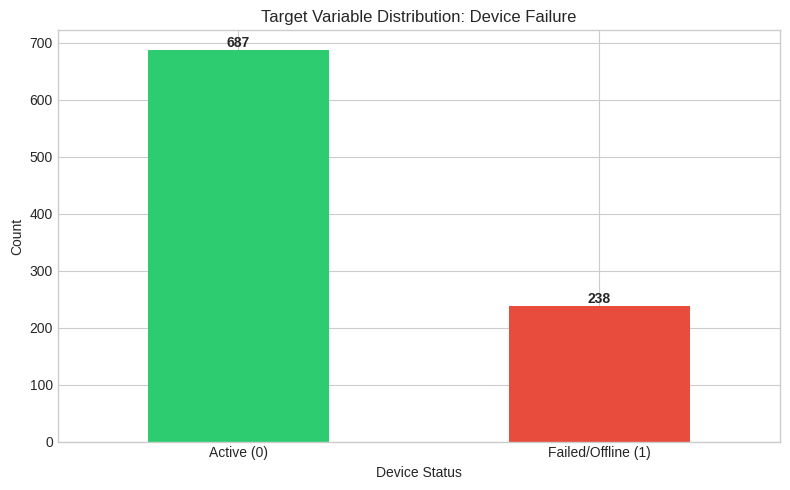

In [13]:
# Target variable distribution
print("Target Variable Distribution:")
print(ml_data['device_failed'].value_counts())
print(f"\nFailure Rate: {ml_data['device_failed'].mean()*100:.2f}%")

# Visualize target distribution
fig, ax = plt.subplots(figsize=(8, 5))
ml_data['device_failed'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'], ax=ax)
ax.set_xlabel('Device Status')
ax.set_ylabel('Count')
ax.set_title('Target Variable Distribution: Device Failure')
ax.set_xticklabels(['Active (0)', 'Failed/Offline (1)'], rotation=0)
for i, v in enumerate(ml_data['device_failed'].value_counts()):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

##  Data Preprocessing

In [14]:
# Check for missing values
print("Missing Values:")
missing = ml_data.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

Missing Values:
No missing values!


In [15]:
# Encode categorical variables
print("Categorical Variables:")
print(f"  - device_type: {ml_data['device_type'].unique()}")
print(f"  - city: {ml_data['city'].unique()}")
print(f"  - home_type: {ml_data['home_type'].unique()}")

Categorical Variables:
  - device_type: ['motion_sensor' 'camera' 'thermostat' 'door_lock']
  - city: ['Seattle' 'Boston' 'Austin' 'San Francisco' 'New York' 'Chicago']
  - home_type: ['condo' 'apartment' 'house']


In [16]:
# Create a copy for ML processing
df = ml_data.copy()

# Label encode categorical variables
label_encoders = {}
categorical_cols = ['device_type', 'city', 'home_type']

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

device_type encoding: {'camera': np.int64(0), 'door_lock': np.int64(1), 'motion_sensor': np.int64(2), 'thermostat': np.int64(3)}
city encoding: {'Austin': np.int64(0), 'Boston': np.int64(1), 'Chicago': np.int64(2), 'New York': np.int64(3), 'San Francisco': np.int64(4), 'Seattle': np.int64(5)}
home_type encoding: {'apartment': np.int64(0), 'condo': np.int64(1), 'house': np.int64(2)}


In [17]:
# Define features and target
feature_columns = [
    'device_type_encoded', 'device_age_days', 'city_encoded', 'home_type_encoded',
    'total_readings', 'active_days', 'avg_numeric_value', 'max_numeric_value',
    'min_numeric_value', 'variance_numeric', 'readings_per_day',
    'temp_readings', 'motion_readings', 'camera_motion_readings', 'door_state_readings',
    'avg_temperature', 'avg_motion', 'motion_detection_rate',
    'total_alerts', 'high_severity_alerts', 'medium_severity_alerts', 'days_with_alerts',
    'devices_in_home', 'offline_devices_in_home', 'home_offline_rate',
    'recent_readings_7d', 'recent_avg_value_7d'
]

X = df[feature_columns]
y = df['device_failed']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

Feature matrix shape: (925, 27)
Target vector shape: (925,)

Features used (27):
  1. device_type_encoded
  2. device_age_days
  3. city_encoded
  4. home_type_encoded
  5. total_readings
  6. active_days
  7. avg_numeric_value
  8. max_numeric_value
  9. min_numeric_value
  10. variance_numeric
  11. readings_per_day
  12. temp_readings
  13. motion_readings
  14. camera_motion_readings
  15. door_state_readings
  16. avg_temperature
  17. avg_motion
  18. motion_detection_rate
  19. total_alerts
  20. high_severity_alerts
  21. medium_severity_alerts
  22. days_with_alerts
  23. devices_in_home
  24. offline_devices_in_home
  25. home_offline_rate
  26. recent_readings_7d
  27. recent_avg_value_7d


In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in testing set:")
print(y_test.value_counts())

Training set: 740 samples
Testing set: 185 samples

Class distribution in training set:
device_failed
0    550
1    190
Name: count, dtype: int64

Class distribution in testing set:
device_failed
0    137
1     48
Name: count, dtype: int64


In [19]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## Model Training and Evaluation

###  Baseline Model: Logistic Regression

In [20]:
# Baseline Model: Logistic Regression

print("BASELINE MODEL: Logistic Regression")


lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"\nLogistic Regression Results:")
print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  AUC-ROC:  {auc_lr:.4f}")
print(f"  F1-Score: {f1_lr:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Active', 'Failed']))

BASELINE MODEL: Logistic Regression

Logistic Regression Results:
  Accuracy: 0.7946
  AUC-ROC:  0.8136
  F1-Score: 0.5476

Classification Report:
              precision    recall  f1-score   support

      Active       0.83      0.91      0.87       137
      Failed       0.64      0.48      0.55        48

    accuracy                           0.79       185
   macro avg       0.74      0.69      0.71       185
weighted avg       0.78      0.79      0.78       185



###  Advanced Model 1: Random Forest

In [21]:
# Advanced Model 1: Random Forest
print("ADVANCED MODEL 1: Random Forest")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)  # Random Forest doesn't require scaling

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"\nRandom Forest Results:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  AUC-ROC:  {auc_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Active', 'Failed']))

ADVANCED MODEL 1: Random Forest

Random Forest Results:
  Accuracy: 0.7189
  AUC-ROC:  0.7669
  F1-Score: 0.3158

Classification Report:
              precision    recall  f1-score   support

      Active       0.77      0.88      0.82       137
      Failed       0.43      0.25      0.32        48

    accuracy                           0.72       185
   macro avg       0.60      0.57      0.57       185
weighted avg       0.68      0.72      0.69       185



### Advanced Model 2: Gradient Boosting

In [22]:
# Advanced Model 2: Gradient Boosting

print("ADVANCED MODEL 2: Gradient Boosting")


gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
f1_gb = f1_score(y_test, y_pred_gb)

print(f"\nGradient Boosting Results:")
print(f"  Accuracy: {accuracy_gb:.4f}")
print(f"  AUC-ROC:  {auc_gb:.4f}")
print(f"  F1-Score: {f1_gb:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Active', 'Failed']))

ADVANCED MODEL 2: Gradient Boosting

Gradient Boosting Results:
  Accuracy: 0.6865
  AUC-ROC:  0.7237
  F1-Score: 0.3556

Classification Report:
              precision    recall  f1-score   support

      Active       0.78      0.81      0.79       137
      Failed       0.38      0.33      0.36        48

    accuracy                           0.69       185
   macro avg       0.58      0.57      0.57       185
weighted avg       0.67      0.69      0.68       185



###  Model Comparison Summary

In [23]:
# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_gb],
    'AUC-ROC': [auc_lr, auc_rf, auc_gb],
    'F1-Score': [f1_lr, f1_rf, f1_gb]
})


print("MODEL COMPARISON SUMMARY")

print(model_comparison.to_string(index=False))

# Identify best model
best_model_idx = model_comparison['AUC-ROC'].idxmax()
best_model = model_comparison.loc[best_model_idx, 'Model']
print(f"\n*** Best Model (by AUC-ROC): {best_model} ***")

MODEL COMPARISON SUMMARY
                         Model  Accuracy  AUC-ROC  F1-Score
Logistic Regression (Baseline)  0.794595 0.813564  0.547619
                 Random Forest  0.718919 0.766880  0.315789
             Gradient Boosting  0.686486 0.723692  0.355556

*** Best Model (by AUC-ROC): Logistic Regression (Baseline) ***


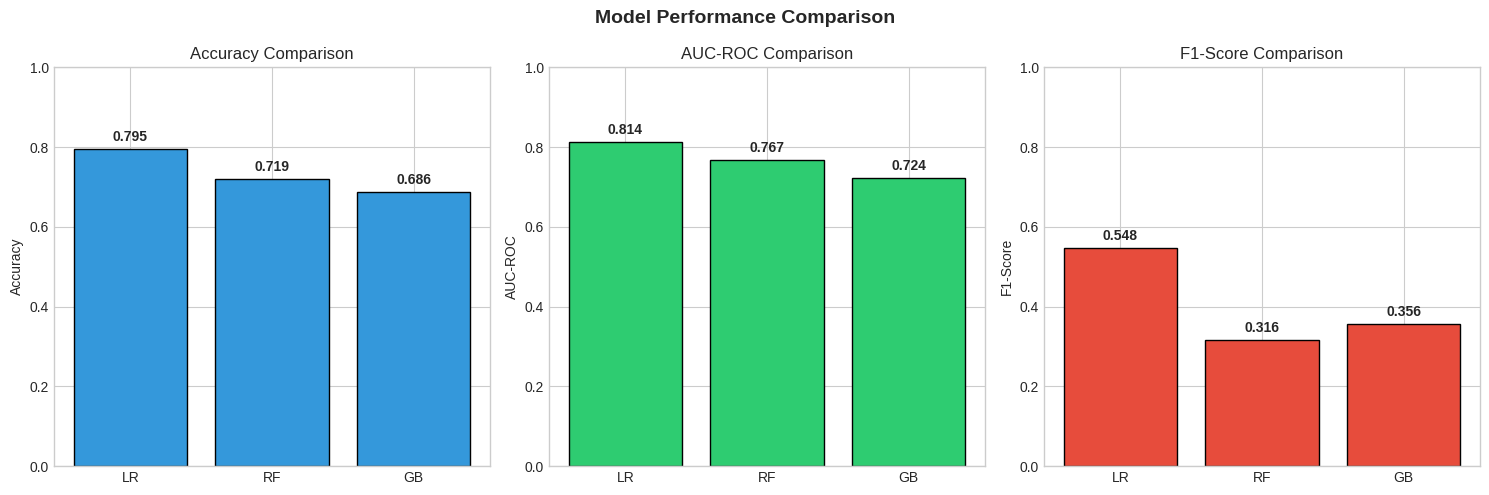

In [24]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Accuracy', 'AUC-ROC', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = model_comparison[metric]
    bars = ax.bar(model_comparison['Model'], values, color=colors[idx], edgecolor='black')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim(0, 1)
    ax.set_xticklabels(['LR', 'RF', 'GB'])

    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

##  Model Evaluation Visualizations

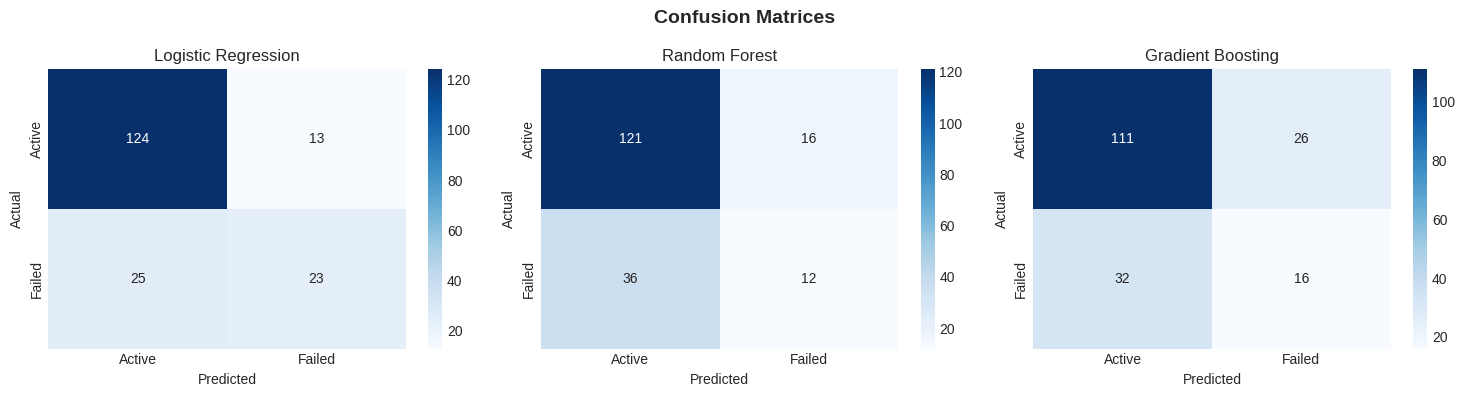

In [26]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb)
]

for idx, (name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Active', 'Failed'], yticklabels=['Active', 'Failed'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(name)

plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

##  Feature Importance Analysis

In [27]:
# Feature importance from Random Forest
rf_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance.head(15).to_string(index=False))

Random Forest Feature Importance:
                Feature  Importance
      home_offline_rate    0.229601
offline_devices_in_home    0.164914
        device_age_days    0.154321
       variance_numeric    0.069597
    recent_avg_value_7d    0.065411
      avg_numeric_value    0.061483
           city_encoded    0.049787
  motion_detection_rate    0.038386
      home_type_encoded    0.029178
        devices_in_home    0.027959
        avg_temperature    0.024681
             avg_motion    0.022572
      max_numeric_value    0.011349
      min_numeric_value    0.009607
    device_type_encoded    0.006992


In [28]:
# Feature importance from Gradient Boosting
gb_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Gradient Boosting Feature Importance:")
print(gb_importance.head(15).to_string(index=False))

Gradient Boosting Feature Importance:
                Feature  Importance
        device_age_days    0.283114
      home_offline_rate    0.247676
offline_devices_in_home    0.091907
    recent_avg_value_7d    0.087633
       variance_numeric    0.058856
      avg_numeric_value    0.038516
  motion_detection_rate    0.036448
           city_encoded    0.033757
      home_type_encoded    0.023798
 medium_severity_alerts    0.018123
        devices_in_home    0.014489
             avg_motion    0.014213
        avg_temperature    0.010601
      max_numeric_value    0.007439
      min_numeric_value    0.006891


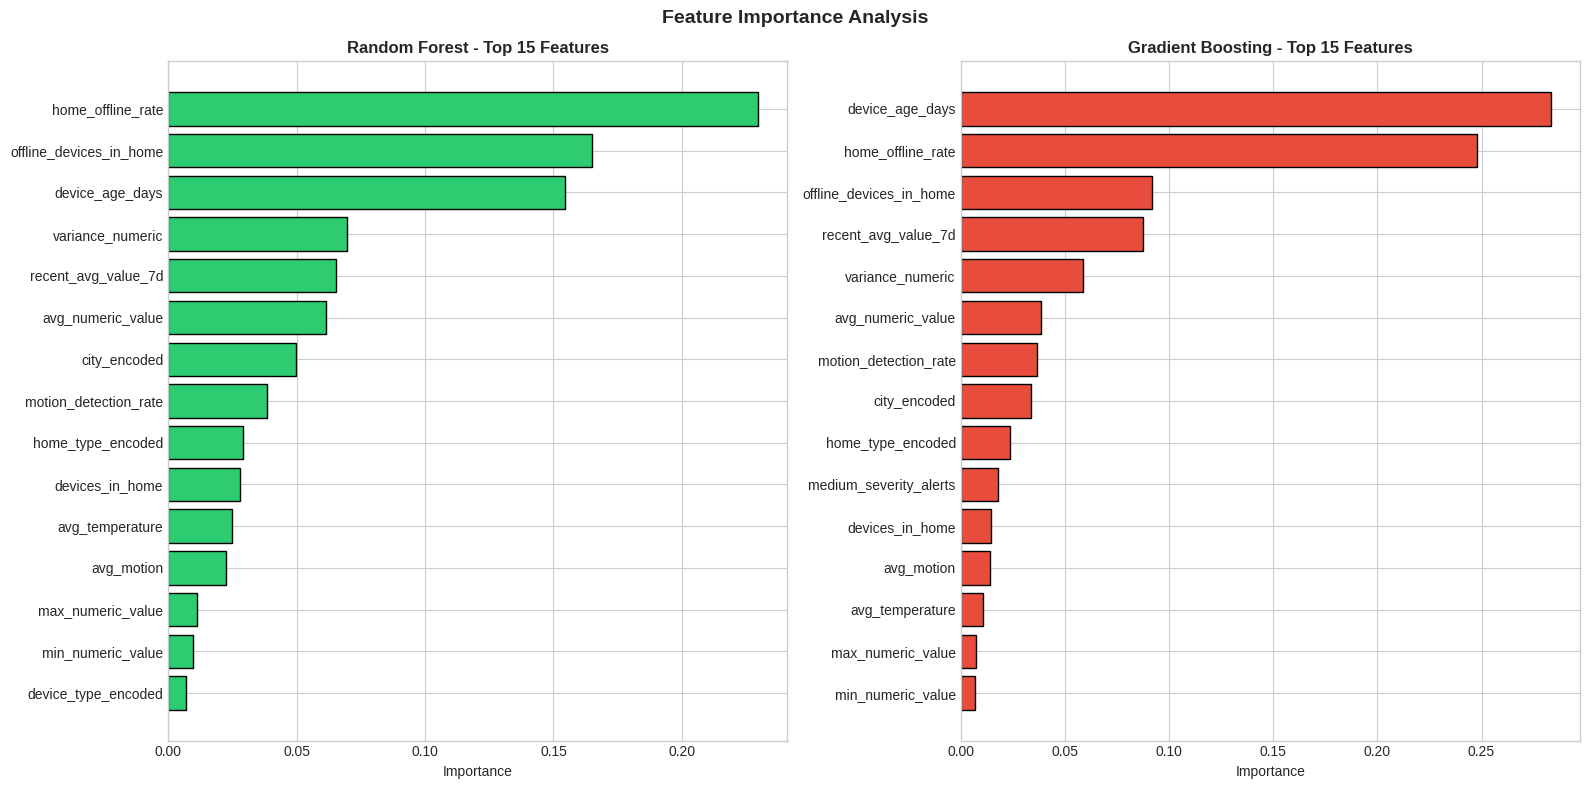

In [29]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest Feature Importance
top_n = 15
rf_top = rf_importance.head(top_n)
axes[0].barh(rf_top['Feature'], rf_top['Importance'], color='#2ecc71', edgecolor='black')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features', fontweight='bold')
axes[0].invert_yaxis()

# Gradient Boosting Feature Importance
gb_top = gb_importance.head(top_n)
axes[1].barh(gb_top['Feature'], gb_top['Importance'], color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting - Top 15 Features', fontweight='bold')
axes[1].invert_yaxis()

plt.suptitle('Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [30]:
# Logistic Regression Coefficients (for interpretability)
lr_coef = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("Logistic Regression Coefficients (Top 15 by absolute value):")
print(lr_coef.head(15).to_string(index=False))

Logistic Regression Coefficients (Top 15 by absolute value):
                Feature  Coefficient
      home_offline_rate     1.027892
  motion_detection_rate    -0.651363
       variance_numeric     0.512321
    recent_avg_value_7d    -0.487099
       days_with_alerts     0.359103
    door_state_readings    -0.315394
        motion_readings     0.296259
offline_devices_in_home     0.187524
             avg_motion     0.163146
   high_severity_alerts    -0.151040
           total_alerts    -0.150336
 camera_motion_readings     0.122404
          temp_readings    -0.098518
        device_age_days     0.094988
 medium_severity_alerts    -0.068592


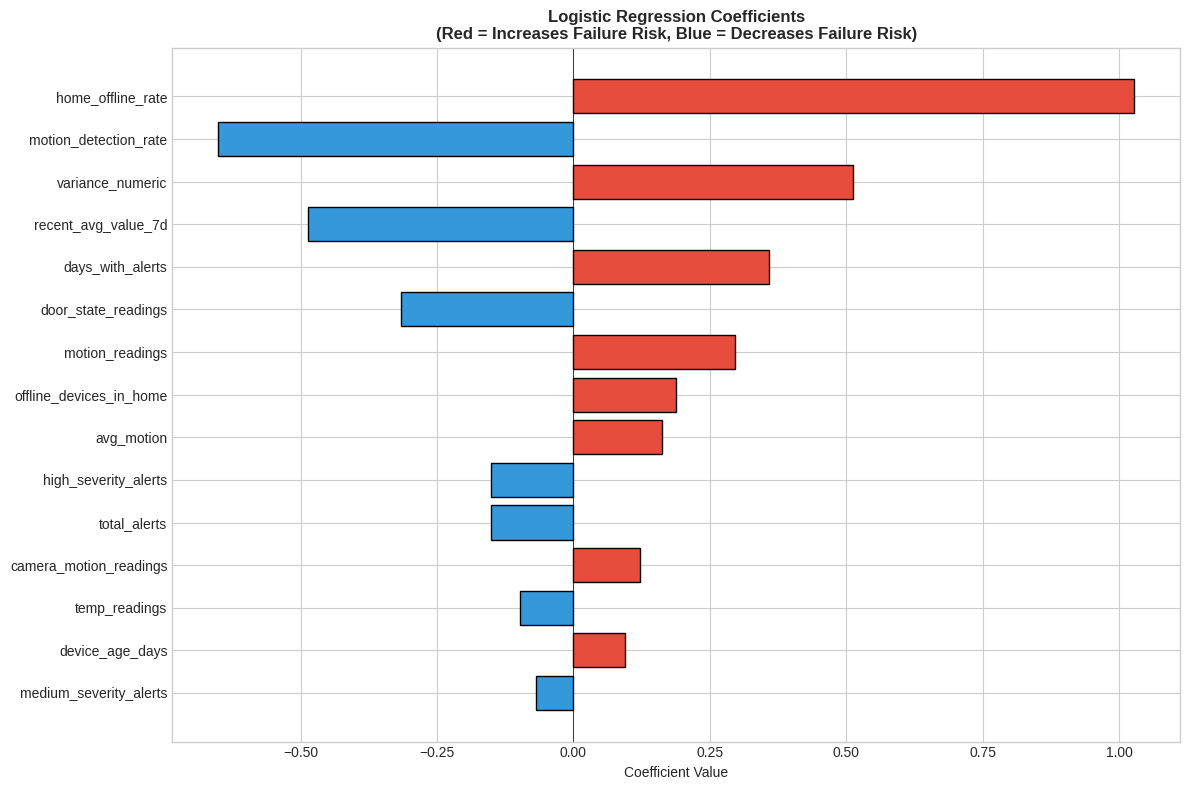

In [31]:
# Visualize Logistic Regression Coefficients
fig, ax = plt.subplots(figsize=(12, 8))

lr_top = lr_coef.head(15)
colors = ['#e74c3c' if x > 0 else '#3498db' for x in lr_top['Coefficient']]
ax.barh(lr_top['Feature'], lr_top['Coefficient'], color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Coefficient Value')
ax.set_title('Logistic Regression Coefficients\n(Red = Increases Failure Risk, Blue = Decreases Failure Risk)',
             fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

##  Cross-Validation Analysis

In [32]:
# Cross-validation for robust evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("5-Fold Cross-Validation Results:")
print("="*50)

# Logistic Regression CV
lr_cv_scores = cross_val_score(LogisticRegression(random_state=42, max_iter=1000),
                               X_train_scaled, y_train, cv=cv, scoring='roc_auc')
print(f"Logistic Regression AUC: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std()*2:.4f})")

# Random Forest CV
rf_cv_scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
                               X_train, y_train, cv=cv, scoring='roc_auc')
print(f"Random Forest AUC:       {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std()*2:.4f})")

# Gradient Boosting CV
gb_cv_scores = cross_val_score(GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
                               X_train, y_train, cv=cv, scoring='roc_auc')
print(f"Gradient Boosting AUC:   {gb_cv_scores.mean():.4f} (+/- {gb_cv_scores.std()*2:.4f})")

5-Fold Cross-Validation Results:
Logistic Regression AUC: 0.7786 (+/- 0.0487)
Random Forest AUC:       0.7333 (+/- 0.0416)
Gradient Boosting AUC:   0.7275 (+/- 0.0608)


##  Additional Analysis: Failure Patterns by Device Type

In [33]:
# Analyze failure rate by device type
failure_by_type = ml_data.groupby('device_type').agg({
    'device_failed': ['sum', 'count', 'mean']
}).round(4)
failure_by_type.columns = ['Failed_Count', 'Total_Count', 'Failure_Rate']
failure_by_type = failure_by_type.sort_values('Failure_Rate', ascending=False)

print("Failure Rate by Device Type:")
print(failure_by_type)

Failure Rate by Device Type:
               Failed_Count  Total_Count  Failure_Rate
device_type                                           
motion_sensor            73          234        0.3120
door_lock                59          240        0.2458
thermostat               52          219        0.2374
camera                   54          232        0.2328


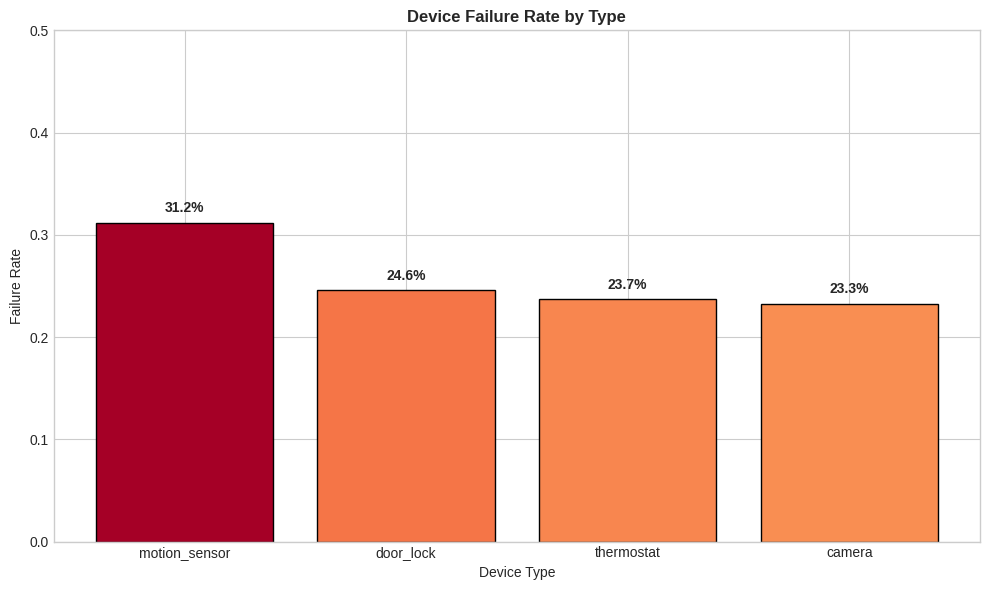

In [34]:
# Visualize failure rate by device type
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.RdYlGn_r(failure_by_type['Failure_Rate'] / failure_by_type['Failure_Rate'].max())
bars = ax.bar(failure_by_type.index, failure_by_type['Failure_Rate'], color=colors, edgecolor='black')
ax.set_xlabel('Device Type')
ax.set_ylabel('Failure Rate')
ax.set_title('Device Failure Rate by Type', fontweight='bold')
ax.set_ylim(0, 0.5)

for bar, rate in zip(bars, failure_by_type['Failure_Rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{rate:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('failure_by_device_type.png', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
# Analyze failure by device age
df['age_category'] = pd.cut(df['device_age_days'],
                            bins=[0, 180, 365, 545, 730, float('inf')],
                            labels=['0-6 months', '6-12 months', '12-18 months', '18-24 months', '24+ months'])

failure_by_age = df.groupby('age_category').agg({
    'device_failed': ['sum', 'count', 'mean']
}).round(4)
failure_by_age.columns = ['Failed_Count', 'Total_Count', 'Failure_Rate']

print("\nFailure Rate by Device Age:")
print(failure_by_age)


Failure Rate by Device Age:
              Failed_Count  Total_Count  Failure_Rate
age_category                                         
0-6 months              63          227        0.2775
6-12 months             60          236        0.2542
12-18 months            55          240        0.2292
18-24 months            60          222        0.2703
24+ months               0            0           NaN


In [36]:
# Generate final summary dataframe
final_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC-ROC', 'F1-Score', 'CV AUC Mean', 'CV AUC Std'],
    'Logistic Regression': [f'{accuracy_lr:.4f}', f'{auc_lr:.4f}', f'{f1_lr:.4f}',
                           f'{lr_cv_scores.mean():.4f}', f'{lr_cv_scores.std():.4f}'],
    'Random Forest': [f'{accuracy_rf:.4f}', f'{auc_rf:.4f}', f'{f1_rf:.4f}',
                     f'{rf_cv_scores.mean():.4f}', f'{rf_cv_scores.std():.4f}'],
    'Gradient Boosting': [f'{accuracy_gb:.4f}', f'{auc_gb:.4f}', f'{f1_gb:.4f}',
                         f'{gb_cv_scores.mean():.4f}', f'{gb_cv_scores.std():.4f}']
})

print("="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(final_summary.to_string(index=False))

FINAL MODEL PERFORMANCE SUMMARY
     Metric Logistic Regression Random Forest Gradient Boosting
   Accuracy              0.7946        0.7189            0.6865
    AUC-ROC              0.8136        0.7669            0.7237
   F1-Score              0.5476        0.3158            0.3556
CV AUC Mean              0.7786        0.7333            0.7275
 CV AUC Std              0.0244        0.0208            0.0304


In [37]:
# Export summary to CSV
final_summary.to_csv('model_performance_summary.csv', index=False)
model_comparison.to_csv('model_comparison.csv', index=False)
rf_importance.to_csv('rf_feature_importance.csv', index=False)
gb_importance.to_csv('gb_feature_importance.csv', index=False)

print("\nExported files:")
print("  - device_failure_features.csv (ML dataset)")
print("  - model_performance_summary.csv")
print("  - model_comparison.csv")
print("  - rf_feature_importance.csv")
print("  - gb_feature_importance.csv")
print("  - target_distribution.png")
print("  - model_comparison.png")
print("  - roc_curves.png")
print("  - confusion_matrices.png")
print("  - feature_importance.png")
print("  - lr_coefficients.png")
print("  - failure_by_device_type.png")


Exported files:
  - device_failure_features.csv (ML dataset)
  - model_performance_summary.csv
  - model_comparison.csv
  - rf_feature_importance.csv
  - gb_feature_importance.csv
  - target_distribution.png
  - model_comparison.png
  - roc_curves.png
  - confusion_matrices.png
  - feature_importance.png
  - lr_coefficients.png
  - failure_by_device_type.png


# TASK 4 :  VISUALIZATIONS & INSIGHTS

In [51]:

conn = sqlite3.connect("smart_home.db")
# Alerts by City
df_city = pd.read_sql_query('''
    SELECT h.city, COUNT(a.alert_id) AS TotalAlerts
    FROM homes h
    LEFT JOIN devices d ON h.home_id = d.home_id
    LEFT JOIN alerts a ON a.device_id = d.device_id
    GROUP BY h.city
    ORDER BY TotalAlerts DESC
''', conn)

# Alerts by Home Type
df_home = pd.read_sql_query('''
    SELECT h.home_type, COUNT(a.alert_id) AS TotalAlerts
    FROM homes h
    LEFT JOIN devices d ON h.home_id = d.home_id
    LEFT JOIN alerts a ON a.device_id = d.device_id
    GROUP BY h.home_type
    ORDER BY TotalAlerts DESC
''', conn)

# Device Installations by Month
df_install = pd.read_sql_query('''
    SELECT STRFTIME('%m', install_date) as InstallMonth, COUNT(*) as Count
    FROM devices
    GROUP BY InstallMonth
    ORDER BY InstallMonth
''', conn)

# Treemap: Alerts by City & Severity
df_tree = pd.read_sql_query('''
    SELECT h.city, a.severity, COUNT(a.alert_id) AS TotalAlerts
    FROM alerts a
    LEFT JOIN devices d ON a.device_id = d.device_id
    LEFT JOIN homes h ON d.home_id = h.home_id
    GROUP BY h.city, a.severity
    ORDER BY h.city, a.severity
''', conn)

# Daily Alerts
df_daily = pd.read_sql_query('''
    SELECT strftime('%Y-%m-%d', alert_datetime) as Date,
           COUNT(alert_id) AS TotalAlerts
    FROM alerts
    GROUP BY Date
    ORDER BY Date
''', conn)

# =============================================================================
# ML MODEL FOR ROC CURVE
# =============================================================================

feature_query = """
WITH
device_info AS (
    SELECT d.device_id, d.home_id, d.device_type, d.status,
        CAST(julianday('2025-11-16') - julianday(d.install_date) AS INTEGER) AS device_age_days,
        h.city, h.home_type
    FROM devices d
    JOIN homes h ON d.home_id = h.home_id
),
sensor_stats AS (
    SELECT device_id,
        COUNT(*) AS total_readings,
        AVG(value_numeric) AS avg_numeric_value,
        AVG(value_numeric * value_numeric) - AVG(value_numeric) * AVG(value_numeric) AS variance_numeric
    FROM sensor_readings
    GROUP BY device_id
),
home_stats AS (
    SELECT home_id,
        COUNT(*) AS devices_in_home,
        SUM(CASE WHEN status='offline' THEN 1.0 ELSE 0.0 END) / COUNT(*) AS home_offline_rate
    FROM devices
    GROUP BY home_id
),
recent_activity AS (
    SELECT device_id, AVG(value_numeric) AS recent_avg_value_7d
    FROM sensor_readings
    WHERE reading_datetime >= datetime('2025-11-09')
    GROUP BY device_id
)
SELECT
    di.device_type, di.device_age_days, di.city, di.home_type,
    COALESCE(ss.total_readings, 0) AS total_readings,
    COALESCE(ss.avg_numeric_value, 0) AS avg_numeric_value,
    COALESCE(ss.variance_numeric, 0) AS variance_numeric,
    hs.devices_in_home, hs.home_offline_rate,
    COALESCE(ra.recent_avg_value_7d, 0) AS recent_avg_value_7d,
    CASE WHEN di.status='offline' THEN 1 ELSE 0 END AS device_failed
FROM device_info di
LEFT JOIN sensor_stats ss ON di.device_id = ss.device_id
LEFT JOIN home_stats hs ON di.home_id = hs.home_id
LEFT JOIN recent_activity ra ON di.device_id = ra.device_id
"""

ml_data = pd.read_sql_query(feature_query, conn)
conn.close()

# Prepare ML features
df_ml = ml_data.copy()
for col in ['device_type', 'city', 'home_type']:
    df_ml[col + '_encoded'] = LabelEncoder().fit_transform(df_ml[col])

feature_cols = ['device_type_encoded', 'device_age_days', 'city_encoded', 'home_type_encoded',
                'total_readings', 'avg_numeric_value', 'variance_numeric',
                'devices_in_home', 'home_offline_rate', 'recent_avg_value_7d']

X = df_ml[feature_cols]
y = df_ml['device_failed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
lr = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_scaled, y_train)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42).fit(X_train, y_train)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42).fit(X_train, y_train)

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])

auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1])
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
auc_gb = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])

# =============================================================================
# BUILD DASHBOARD
# =============================================================================

# Color palette
BLUE = '#3498db'
GREEN = '#27ae60'
ORANGE = '#e67e22'
RED = '#e74c3c'
GRAY = '#95a5a6'

fig = make_subplots(
    rows=3, cols=2,
    specs=[
        [{"type": "bar"}, {"type": "bar"}],
        [{"type": "xy"}, {"type": "treemap"}],
        [{"type": "xy"}, {"type": "xy"}]
    ],
    subplot_titles=[
        "Alerts by City",
        "Alerts by Home Type",
        "Device Installations by Month",
        "Alerts by City & Severity",
        "Daily Alerts Trend",
        "ML Model ROC Curves"
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.10
)

# -----------------------------------------------------------------------------
# Row 1: Bar Charts
# -----------------------------------------------------------------------------

# Chart 1: Alerts by City
fig.add_trace(
    go.Bar(x=df_city["TotalAlerts"], y=df_city["city"], orientation="h",
           marker_color=BLUE, showlegend=False),
    row=1, col=1
)

# Chart 2: Alerts by Home Type
fig.add_trace(
    go.Bar(x=df_home["TotalAlerts"], y=df_home["home_type"], orientation="h",
           marker_color=ORANGE, showlegend=False),
    row=1, col=2
)

# -----------------------------------------------------------------------------
# Row 2: Installations & Treemap
# -----------------------------------------------------------------------------

# Chart 3: Device Installations by Month
fig.add_trace(
    go.Bar(x=df_install["InstallMonth"], y=df_install["Count"],
           marker_color=GREEN, showlegend=False),
    row=2, col=1
)

# Chart 4: Treemap - Alerts by City & Severity
treemap = px.treemap(
    df_tree,
    path=["city", "severity"],
    values="TotalAlerts",
    color="TotalAlerts",
    color_continuous_scale=["#a8e6cf", "#ff8b94"]
)
fig.add_trace(treemap.data[0], row=2, col=2)

# -----------------------------------------------------------------------------
# Row 3: Daily Trend & ROC Curves
# -----------------------------------------------------------------------------

# Chart 5: Daily Alerts Trend
fig.add_trace(
    go.Scatter(x=df_daily["Date"], y=df_daily["TotalAlerts"],
               mode="lines+markers", line=dict(color=RED, width=2),
               marker=dict(size=4), showlegend=False),
    row=3, col=1
)

# Chart 6: ROC Curves
fig.add_trace(
    go.Scatter(x=fpr_lr, y=tpr_lr, mode='lines',
               name=f'Logistic Reg (AUC={auc_lr:.3f})',
               line=dict(color=GREEN, width=2.5)),
    row=3, col=2
)
fig.add_trace(
    go.Scatter(x=fpr_rf, y=tpr_rf, mode='lines',
               name=f'Random Forest (AUC={auc_rf:.3f})',
               line=dict(color=BLUE, width=2.5)),
    row=3, col=2
)
fig.add_trace(
    go.Scatter(x=fpr_gb, y=tpr_gb, mode='lines',
               name=f'Gradient Boost (AUC={auc_gb:.3f})',
               line=dict(color=ORANGE, width=2.5)),
    row=3, col=2
)
fig.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
               name='Random', line=dict(color=GRAY, width=1, dash='dash')),
    row=3, col=2
)

# -----------------------------------------------------------------------------
# Axis Labels
# -----------------------------------------------------------------------------

fig.update_xaxes(title_text="Alerts", row=1, col=1)
fig.update_xaxes(title_text="Alerts", row=1, col=2)
fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_xaxes(title_text="False Positive Rate", range=[0, 1], row=3, col=2)

fig.update_yaxes(title_text="City", row=1, col=1)
fig.update_yaxes(title_text="Home Type", row=1, col=2)
fig.update_yaxes(title_text="Devices", row=2, col=1)
fig.update_yaxes(title_text="Alerts", row=3, col=1)
fig.update_yaxes(title_text="True Positive Rate", range=[0, 1], row=3, col=2)

# -----------------------------------------------------------------------------
# Layout
# -----------------------------------------------------------------------------

fig.update_layout(
    title=dict(
        text="Smart Home IoT Analytics Dashboard",
        font=dict(size=22, color='#2c3e50'),
        x=0.5
    ),
    height=900,
    width=1100,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.12,
        xanchor="center",
        x=0.75,
        font=dict(size=10)
    ),
    margin=dict(t=80, l=80, r=40, b=100),
    paper_bgcolor='white',
    plot_bgcolor='#fafafa',
    coloraxis_showscale=False
)

# Add subtle gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#eee')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#eee')

fig.show()

# Save as HTML (optional)
# fig.write_html("smart_home_dashboard.html")